In [ ]:
%pip install -r ../requirements.txt

In [1]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

In [2]:
# Get all exercises from all workouts
all_exercises = []
for workout in wld.workouts:
    all_exercises.extend(workout.exercises)
print(f"Total exercises: {len(all_exercises)}")

Total exercises: 8821


In [6]:
from collections import Counter

favorite_exercises = [
    "70 degree incline press",
    "Flat Barbell Bench Press",
    "Incline Barbell Bench Press",
    "T-Bar Ben Rows",
    "Close-grip Bench Press",
    "Barbell Conventional Curls",
    "Conventional Deadlifts",
    "Sumo Deadlifts",
    "Normal Lat Pulldowns",
    "Low Leg Press",
    "One-arm Overhead Extensions",
    "Barbell Overhead Press",
    "Barbell Preacher Curls",
    "Back Squats",
]

# Count exercise names and iterations, only for reps_weight exercises
exercise_counts = Counter()
for exercise in all_exercises:
    key = f"{exercise.iteration} {exercise.name}" if exercise.iteration else exercise.name
    if key in favorite_exercises:
        exercise_counts[key] += 1

percent_of_total = (sum(exercise_counts.values()) / len(all_exercises)) * 100

print(f"Counts of favorite exercises (representing {sum(exercise_counts.values()):,} exercises, {percent_of_total:.1f}% of total):")
for i, (name, count) in enumerate(exercise_counts.most_common(), 1):
    print(f"{i}. {name}: {count:,} times")

Counts of favorite exercises (representing 2,183 exercises, 24.7% of total):
1. Flat Barbell Bench Press: 369 times
2. One-arm Overhead Extensions: 296 times
3. Close-grip Bench Press: 268 times
4. Barbell Overhead Press: 259 times
5. Back Squats: 183 times
6. Barbell Preacher Curls: 180 times
7. Incline Barbell Bench Press: 162 times
8. Barbell Conventional Curls: 151 times
9. Normal Lat Pulldowns: 123 times
10. Low Leg Press: 54 times
11. Sumo Deadlifts: 48 times
12. 70 degree incline press: 48 times
13. Conventional Deadlifts: 42 times


In [7]:
# Sort all exercises by date before processing PRs
all_exercises.sort(key=lambda x: x.workout().date)

current_one_rms = {}
current_volumes = {}

all_one_rm_prs = []
all_volume_prs = []

for exercise in all_exercises:
    key = f"{exercise.iteration} {exercise.name}" if exercise.iteration else exercise.name
    if key not in favorite_exercises:
        continue
    one_rm = max([set.oneRM for set in exercise.sets])
    volume = sum([set.volume for set in exercise.sets])
    date = exercise.workout().date
    if one_rm > current_one_rms.get(key, 0):
        if key in current_one_rms:
            all_one_rm_prs.append((date, key, one_rm))
        current_one_rms[key] = one_rm
    if volume > current_volumes.get(key, 0):
        if key in current_volumes:
            all_volume_prs.append((date, key, volume))
        current_volumes[key] = volume

print(f"Total 1RM PRs recorded: {len(all_one_rm_prs):,}")
print(f"Total volume PRs recorded: {len(all_volume_prs):,}")

Total 1RM PRs recorded: 229
Total volume PRs recorded: 178


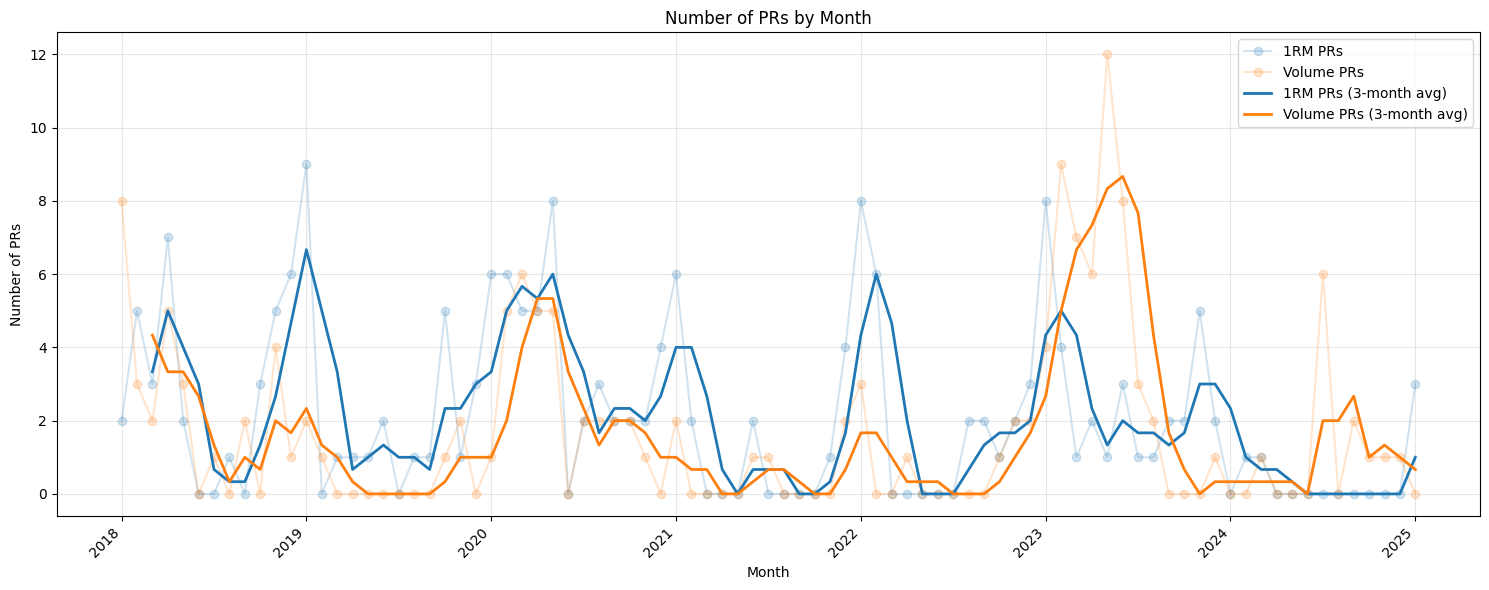

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from datetime import datetime

# Create dictionaries to store PR counts by month
one_rm_prs_by_month = defaultdict(int)
volume_prs_by_month = defaultdict(int)

# Convert dates to month keys and count PRs
for date, _, _ in all_one_rm_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    one_rm_prs_by_month[month_key] += 1

for date, _, _ in all_volume_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    volume_prs_by_month[month_key] += 1

# Generate all months between min and max dates
start_date = datetime(2018, 1, 1)
end_date = datetime.now()
all_months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

# Create lists for plotting
months = all_months
one_rm_counts = [one_rm_prs_by_month[month] for month in all_months]
volume_counts = [volume_prs_by_month[month] for month in all_months]

# Create the plot
plt.figure(figsize=(15, 6))

# Plot original lines with reduced opacity
line1, = plt.plot(months, one_rm_counts, label="1RM PRs", marker='o', alpha=0.2)
line2, = plt.plot(months, volume_counts, label="Volume PRs", marker='o', alpha=0.2)

# Calculate 3-month rolling averages
window_size = 3
one_rm_rolling = pd.Series(one_rm_counts).rolling(window=window_size).mean()
volume_rolling = pd.Series(volume_counts).rolling(window=window_size).mean()

plt.plot(months, one_rm_rolling, label="1RM PRs (3-month avg)", linewidth=2, color=line1.get_color())
plt.plot(months, volume_rolling, label="Volume PRs (3-month avg)", linewidth=2, color=line2.get_color())

# Customize the plot
plt.title("Number of PRs by Month")
plt.xlabel("Month")
plt.ylabel("Number of PRs")

# Show x-axis labels for Jan 1 of each year
tick_positions = []
tick_labels = []
for i, month in enumerate(months):
    year, month = month.split('-')
    if month == '01':  # January only
        tick_positions.append(i)
        tick_labels.append(f"{year}")

plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()